# Section 3.7 Example: analysis of a bioassay experiment.

I have followed the example in section 3.7 of Bayesian Data Analysis by Gelman et al (third edition, 2014). Below are my results  and some extra analyses I added. Look into the code to see the actual analyses.

#### TODO:
* build the bioassay example using `pymc3` following [this example](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC3.ipynb#Example:-Challenger-Space-Shuttle-Disaster-).
* build example using automatic differentiation variational inference (ADVI). This is interesting for two reasons
    - ADVI uses a Gaussian distribution ([see this example](https://docs.pymc.io/notebooks/variational_api_quickstart.html)).
    - ADVI is a mean-field approximation so we ignore correlations in the posterior ([see this example](https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html)).

## Data & model
First import the data which summarizes trials on 20 individuals.

In [1]:
import sec_3_7 as sec37
from scipy.integrate import simps
import warnings
import numpy as np

# hide warnings in Python 2
warnings.simplefilter(action='ignore', category=UserWarning)

data, feature_names = sec37.get_data()

The the data is expanded to a form suited for __logistic regression__ using MLE packages.

In [2]:
X, y = sec37.inflate_data(data)

As an exercise we group the data representing individuals back to the original summary form presented by Gelman et al. using pandas

In [3]:
grouped = sec37.group_data(X, y)
print(grouped)

      x  ndead  ntot  nalive  pdead
0 -0.86      0     5       5    0.0
1 -0.30      1     5       4    0.2
2 -0.05      3     5       2    0.6
3  0.73      5     5       0    1.0


## MLE estimates

### scikit-learn
Use `scikit-learn` to do logistic regression (MLE). Note that the default regularization has effectively been turned off.

In [4]:
dose, p_dead, x_ld50, _ = sec37.logit_sklean(X, y, feature_names)


*** sklearn ***
Coefficients
   Coef for Dose log g/ml 7.74871833754
   Intercept: 0.846554250746


Plot the result along with point estimates for the death probability at each dose

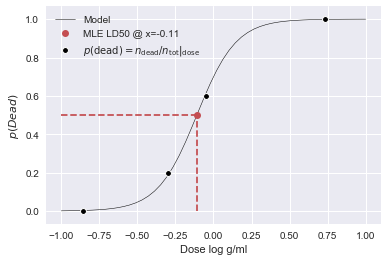

In [5]:
sec37.plot_logistic(dose, p_dead, grouped, x_ld50, estimate_type='MLE',
                    xlabel=feature_names[0], ylabel='$p(Dead)$')

### statsmodels
Also try MLE using `statsmodels`

In [6]:
 params_mle, cov_mle = sec37.logit_statsmodels(X, y)


*** statsmodels ***
Optimization terminated successfully.
         Current function value: 0.294722
         Iterations 9
('params', array([7.74881715, 0.84658023]))
('cov', array([[23.74386507,  3.54598682],
       [ 3.54598682,  1.03853509]]))
('SE', array([4.8727677 , 1.01908542]))
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   20
Model:                          Logit   Df Residuals:                       18
Method:                           MLE   Df Model:                            1
Date:                Fri, 31 May 2019   Pseudo R-squ.:                  0.5717
Time:                        08:33:02   Log-Likelihood:                -5.8944
converged:                       True   LL-Null:                       -13.763
                                        LLR p-value:                 7.280e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
--

### MLE parameter covarience from the Hessian matrix
As an exercise let's calculate the parameter covariance matrix directly from the Hessian evaluated at MLE for the parameters. This should be the same as calculated using statsmodels.

In [7]:
sec37.calc_cov(X, *params_mle[::-1])

('Hessian', array([[ 0.0859372 , -0.29342501],
       [-0.29342501,  1.96476869]]))
('COV', array([[23.74386507,  3.54598682],
       [ 3.54598682,  1.03853509]]))


## Posterior density estimate
Following Gelman I now calculate the posterior density on a grid

In [8]:
(av, bv,
 density,
 a_vals, b_vals,
 delta_a, delta_b) = sec37.posterior_density_grid(data['Dose log g/ml'],
                                                  data['Number of animals'],
                                                  data['Number of deaths'],
                                                  na=500, nb=500)

Normalize the density to a probability distribution assuming constant value in each grid block. 

In [9]:
pdf_grid = sec37.make_pdf_grid(density, delta_a, delta_b)

Get the MAP estimate

In [10]:
idxs_map = pdf_grid.argmax()
map_estimate = av.ravel()[idxs_map], bv.ravel()[idxs_map]
print('MAP estimate (a, b)', map_estimate)

('MAP estimate (a, b)', (0.8617234468937873, 7.835671342685373))


Integrate pdf to validate that we were in fact successful

In [11]:
print('Total posterior probability (validation):', simps(simps(pdf_grid, b_vals), a_vals))

('Total posterior probability (validation):', 0.9999913685930165)


Transform the density into a  multinominal grid

In [12]:
prob_grid = sec37.make_prob_grid(density)

Sum over all grid blocks to validate that we were successful

In [13]:
print('Total posterior probability (validation):', prob_grid.sum())

('Total posterior probability (validation):', 1.0)


Sample the grid to draw (a, b) values from the posterior and plot the density along with with the MAP estimate and the sampled parameter pairs.

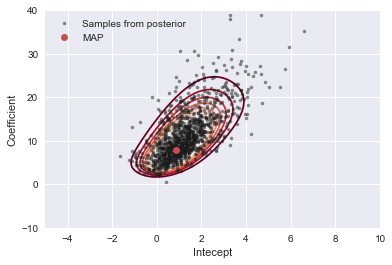

In [14]:
ab_vals = sec37.sample_posterior(a_vals, b_vals, prob_grid, nsamples=1000)
sec37.plot_posterior_density(av, bv, pdf_grid, map_estimate, xysamples=ab_vals)

Plot the sampled values along with thei marginal distributions.

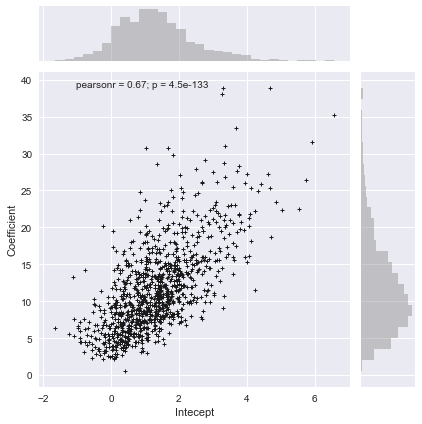

In [15]:
sec37.plot_posterior_samples(ab_vals[:,0], ab_vals[:,1])

## Sampling the joint posterior distribution using MCMC 
As an alternative to the method presented above we could sample the posterior using an MCMC sampler. Below is an example using a quite simple and verbose MCMC sampler. The initial positions for the chains drawn from MLE estimate.

Chain 1. Initial parameters [ 0.23190541 14.83600427]. Acceptance ratio 0.60576
Chain 2. Initial parameters [ 0.1940053  12.60131163]. Acceptance ratio 0.60908
Chain 3. Initial parameters [ 2.89951135 21.4076377 ]. Acceptance ratio 0.5906


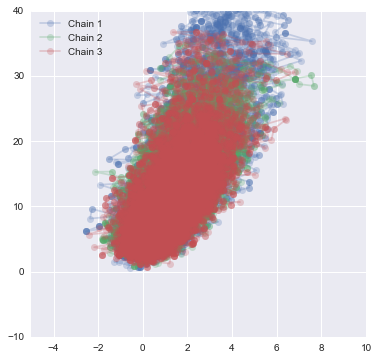

In [16]:
nchains = 3
pars0 = np.random.multivariate_normal(params_mle[::-1], np.rot90(cov_mle, k=2), nchains)
sec37.mcmc(data['Dose log g/ml'],
           data['Number of animals'],
           data['Number of deaths'], 
           pars0, nsamples=25000)

## Posterior predictive check

Using samples from the grid approximation of the posterior distribution I plot corresponding realizations of the logistic curve and LD50 estimates.

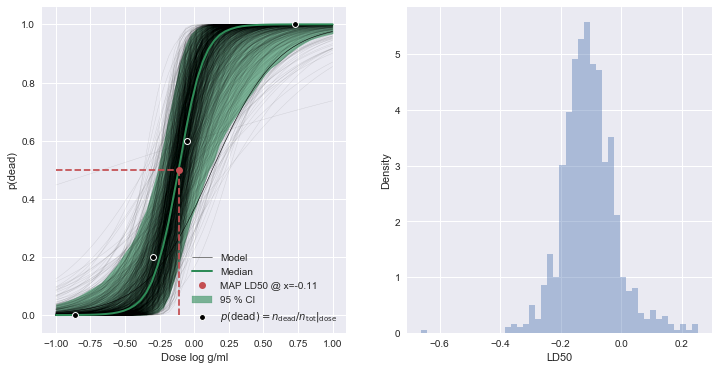

In [17]:
# Only use parameters where b>0 
ab_vals = ab_vals[ab_vals[:,1] > 0]

# LD50 histogram for b > 0
axs = sec37.plot_ld50_hist(ab_vals)

dose, p_dead = sec37.sample_model(ab_vals)
x_ld50_map = -map_estimate[0]/map_estimate[1]
sec37.plot_logistic(dose, p_dead, grouped, x_ld50_map,
                    estimate_type='MAP', alpha=0.1,
                    xlabel=feature_names[0], ylabel='p(dead)',
                    ax=axs[0])

## Summary statistics
To report summary statistics we may approximate the joint posterior distribution by a bivariate normal distribution (see p.86). Also we may compare these statistics to the ones obtained from MLE.

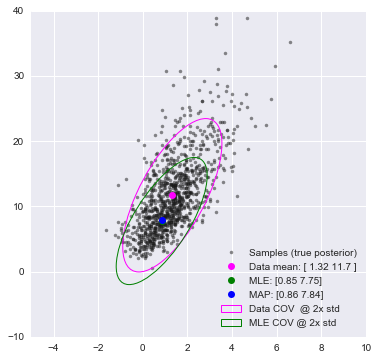

In [18]:
sec37.normal_approximation(ab_vals, map_estimate, params_mle, cov_mle)